# Your First GAN

We will be using only a lightly modified version of a fantastic notebook I found online by Wouter Bulten, found here: https://github.com/wouterbulten/deeplearning-resources/tree/master/notebooks. He also has a great blog post on his personal site that goes into deeper detail than we will cover in our workshop, but be sure to check it out too! https://www.wouterbulten.nl/blog/tech/getting-started-with-generative-adversarial-networks/

This notebook is very resource intensive. I will be using my Deep Learning Virtual Machine instance from my Azure account, running on a Titan GPU powered VM. We will train for around half an hour, which will give us a good visual validation on what the Generator is actually doing.

We start by setting up keras and importing the layers we'll be using for Generative Adversarial Network.

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image

from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
def discriminator():
    net = Sequential()
    input_shape = (28, 28, 1)
    dropout_prob = 0.4
    net.add( Conv2D(64, 5, strides=2, input_shape=input_shape, padding='same'))
    net.add(LeakyReLU())
    
    net.add(Conv2D(128, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(256, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(512, 5, strides=1, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Flatten())
    net.add(Dense(1))
    net.add(Activation('sigmoid'))
    
    return net

In [4]:
net_discriminator = discriminator()
net_discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 256)         0         
__________

In [5]:
def generator():
    
    net = Sequential()
    dropout_prob = 0.4
    
    net.add(Dense(7*7*256, input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    net.add(Reshape((7,7,256)))
    net.add(Dropout(dropout_prob))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(UpSampling2D())
    net.add(Conv2D(64, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(32, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(1, 5, padding='same'))
    net.add(Activation('sigmoid'))
    
    return net
    

In [6]:
net_generator = generator()
net_generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       819328    
__________

In [7]:
optim_discriminator = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-10)
model_discriminator = Sequential()
model_discriminator.add(net_discriminator)
model_discriminator.compile(loss='binary_crossentropy', optimizer=optim_discriminator, metrics=['accuracy'])
model_discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1)                 4311553   
Total params: 4,311,553
Trainable params: 4,311,553
Non-trainable params: 0
_________________________________________________________________


In [8]:
optim_adversarial = Adam(lr=0.0004, clipvalue=1.0, decay=1e-10)
model_adversarial = Sequential()
model_adversarial.add(net_generator)

for layer in net_discriminator.layers:
    layer.trainable = False

model_adversarial.add(net_discriminator)
model_adversarial.compile(loss='binary_crossentropy', optimizer=optim_adversarial, metrics=['accuracy'])
model_adversarial.summary()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________


In [9]:
x_train = input_data.read_data_sets('mnist', one_hot=True).train.images
x_train = x_train.reshape(-1, 28,  28, 1).astype(np.float32)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models

In [11]:
x_train.shape

(55000, 28, 28, 1)

In [12]:
batch_size = 256

vis_noise = np.random.uniform(-1.0, 1.0, size=[16, 100])

loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []

for i in range(2001):
    
    # Select a random set of training images from the mnist dataset
    images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
    # Generate a random noise vector
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    # Use the generator to create fake images from the noise vector
    images_fake = net_generator.predict(noise)
    
    # Create a dataset with fake and real images
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0 

    # Train discriminator for one batch
    d_stats = model_discriminator.train_on_batch(x, y)
    
    # Train the generator
    # The input of th adversarial model is a list of noise vectors. The generator is 'good' if the discriminator classifies
    # all the generated images as real. Therefore, the desired output is a list of all ones.
    y = np.ones([batch_size, 1])
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    a_stats = model_adversarial.train_on_batch(noise, y)
        
    if i % 50 == 0:
        print("{}: [Dis. loss: {:.4f}, acc: {:.4f}] [Gen. loss: {:.4f}, acc: {:.4f}]".format(i, d_stats[0], d_stats[1], a_stats[0], a_stats[1]))

    if i % 100 == 0:
        # Visualize the performance of the generator by producing images from the test vector
        images = net_generator.predict(vis_noise)
        plt.figure(figsize=(10,10))
        for im in range(images.shape[0]):
            plt.subplot(4, 4, im+1)
            image = images[im, :, :, :]
            image = np.reshape(image, [28, 28])            
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(r'images/gan_output/{}.png'.format(i))
        plt.close('all')

C:\Users\admin\Envs\deepvision\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [Dis. loss: 0.6938, acc: 0.5039] [Gen. loss: 2.6236, acc: 0.0000]
50: [Dis. loss: 7.9712, acc: 0.5000] [Gen. loss: 0.0000, acc: 1.0000]
100: [Dis. loss: 7.9712, acc: 0.5000] [Gen. loss: 0.0000, acc: 1.0000]
150: [Dis. loss: 0.7526, acc: 0.5449] [Gen. loss: 1.3987, acc: 0.0352]
200: [Dis. loss: 0.5031, acc: 0.7930] [Gen. loss: 1.1550, acc: 0.1953]
250: [Dis. loss: 0.4175, acc: 0.8281] [Gen. loss: 1.3228, acc: 0.1875]
300: [Dis. loss: 0.2768, acc: 0.9180] [Gen. loss: 2.1077, acc: 0.0391]
350: [Dis. loss: 0.3272, acc: 0.8848] [Gen. loss: 1.8549, acc: 0.0664]
400: [Dis. loss: 0.3961, acc: 0.8281] [Gen. loss: 1.5457, acc: 0.1875]
450: [Dis. loss: 0.5358, acc: 0.7227] [Gen. loss: 1.7701, acc: 0.0703]
500: [Dis. loss: 0.4802, acc: 0.7559] [Gen. loss: 0.9739, acc: 0.4570]
550: [Dis. loss: 0.4564, acc: 0.7949] [Gen. loss: 1.2879, acc: 0.2070]
600: [Dis. loss: 0.4653, acc: 0.7871] [Gen. loss: 1.0820, acc: 0.3555]
650: [Dis. loss: 0.3912, acc: 0.8340] [Gen. loss: 1.1770, acc: 0.3164]
700: [Dis

In [14]:
import imageio

filenames=[r'images/gan_output/{}.png'.format(i*100) for i in range(21)]
images2 = []
for filename in filenames:
    images2.append(imageio.imread(filename))

images2.append(imageio.imread('images/gan_output/2000.png'))
images2.append(imageio.imread('images/gan_output/2000.png'))
images2.append(imageio.imread('images/gan_output/2000.png'))
        
imageio.mimsave(r'images/gan_output/learning2.gif', images2, duration=0.3)

Image(url='images/gan_output/learning2.gif')

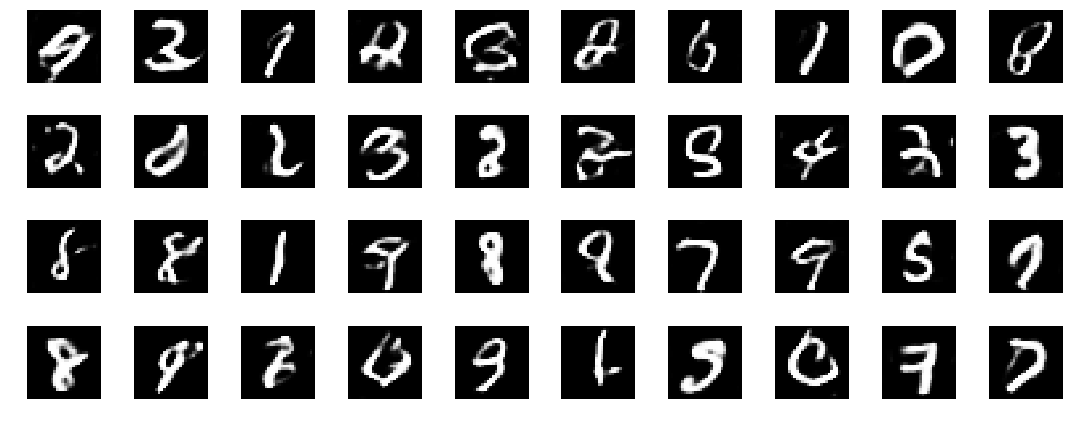

In [15]:
plt.figure(figsize=(15,6))
noise = np.random.uniform(-1.0, 1.0, size=[40, 100])
images = net_generator.predict(noise)

for i in range(40):
    
    image = images[i, :, :, :]
    image = np.reshape(image, [28, 28])
          
    plt.subplot(4, 10, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()